For this 6th tutorial we will study  annual maximum sea level heights in Washington DC. 
Sea levels can get extremely high during coastal storms, especially in combination with high 
tides. For cities at coastlines this can be very problematic. Having a sense of what the X-year
storm would be can be very helpful, for example when constructing safety measures. Here we are 
looking at annual maximum sea level data from a measurment station close to Washington DC.  

Import the data using read.csv() and create a plot of the recorded data. 


In [ ]:
# <Yosmely Bermúdez> comments
#install dependencies
# We need this to install eigen which is needed for SDFC to install correctly
!pip install -q condacolab
import condacolab
condacolab.install()
!conda install eigen
!pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
!pip install https://github.com/njleach/mystatsfunctions/archive/master.zip
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install cartopy
!pip install scipy
!pip install texttable

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats

In [3]:
# <Yosmely Bermúdez> comments
# Mount Google Drive locally
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/Shareddrives/Academy/Courses/Climate/Climatematch/02-Curriculum/Climatematch\ Content\ Folder/W2D4\ -\ Climate\ Response\ -\ Extremes\ \&\ Variability/W2D4\ Tutorials

Mounted at /content/gdrive


In [5]:
import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd


In [6]:
gev = stats.genextreme

In [7]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.coef_
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

In [8]:
data = pd.read_csv('WashingtonDCSSH1930-2022.csv',index_col=0).set_index('years')
data

,ssh
years,
1931,-140
1932,-112
1933,-6
1934,-51
1935,-94
...,...
2018,517
2019,299
2020,257


Text(0, 0.5, 'sea surface height')

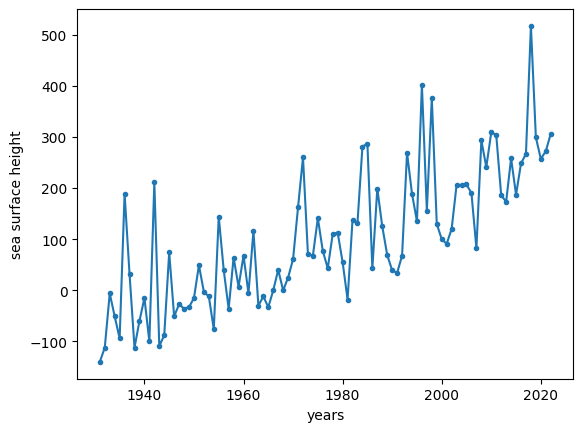

In [ ]:
data.ssh.plot(linestyle='-',marker='.')
plt.ylabel('sea surface height')

Have a good look at the plot of your record… there appear to be an increasing trend. Of course, sea 
level height is strongly dependent on sea surface temperatures, which are rising due to climate change. 
In this case… it is actually appears linear. That means we should account of this non-stationarity. 

In the previous tutorials we assumed the probability density function shape to remains the same
through time. In other words, the precipitation values always derived from the same distribution. But,
today's world so clearly affected by climate change we cannot assume that the pdf remains stable 
For example...temperatures globaly rise so the distribution's location shifts, locally precipitation
becomes more variable so the distribution widens, or the extremes become more extreme so the
distribution tails become thicker. We call this 'non-stationary'.

We can study this more in depth by grouping our data in say three 30-year (climate normal) periods. 
Make one record from 1931 to 1960, one from 1961 to 1990 and one from 1991 to 2020. Then plot the 
histogram of each dataset within the same frame.

In [ ]:
data_period1 = data.iloc[0:30]
data_period2 = data.iloc[30:60]
data_period3 = data.iloc[60:90]

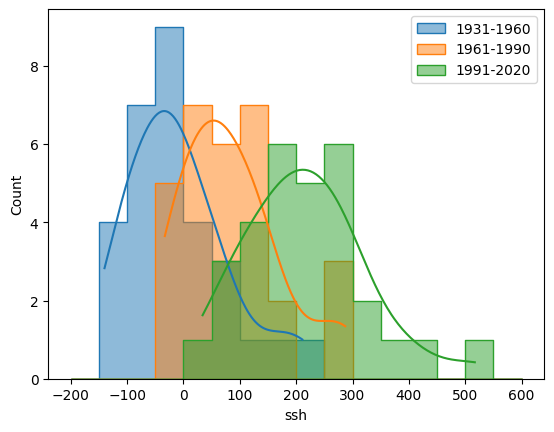

In [ ]:
sns.histplot(data_period1.ssh,bins=np.arange(-200,650,50),color='C0',element='step',alpha=0.5,kde=True,label='1931-1960')
sns.histplot(data_period2.ssh,bins=np.arange(-200,650,50),color='C1',element='step',alpha=0.5,kde=True,label='1961-1990')
sns.histplot(data_period3.ssh,bins=np.arange(-200,650,50),color='C2',element='step',alpha=0.5,kde=True,label='1991-2020')
plt.legend()

In [ ]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['1931-1960'] = [data_period1.ssh.mean(), data_period1.ssh.std(), data_period1.ssh.skew()]
periods_stats['1961-1990'] = [data_period2.ssh.mean(), data_period2.ssh.std(), data_period2.ssh.skew()]
periods_stats['1991-2020'] = [data_period3.ssh.mean(), data_period3.ssh.std(), data_period3.ssh.skew()]

periods_stats = periods_stats.T
periods_stats

,Mean,Standard Deviation,Skew
1931-1960,-9.966667,87.095066,0.922327
1961-1990,85.200000,87.953906,0.854553
1991-2020,216.633333,105.739264,0.701258


It is clear that the moments change over time, especially the mean increases rapidly. Skewness on
the other hand remains similar over time or decreases slightly. Clearly this record is non-stationary.
To see how the entire shape of the distribution changes we can fit a GEV distribution to the record 
of each period and plot the associated pdf:

In [ ]:
fit_period1, model_period1 = ef.fit_return_levels_sdfc(data_period1.ssh.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)
fit_period2, model_period2 = ef.fit_return_levels_sdfc(data_period2.ssh.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)
fit_period3, model_period3 = ef.fit_return_levels_sdfc(data_period3.ssh.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)

Text(0, 0.5, 'Density')

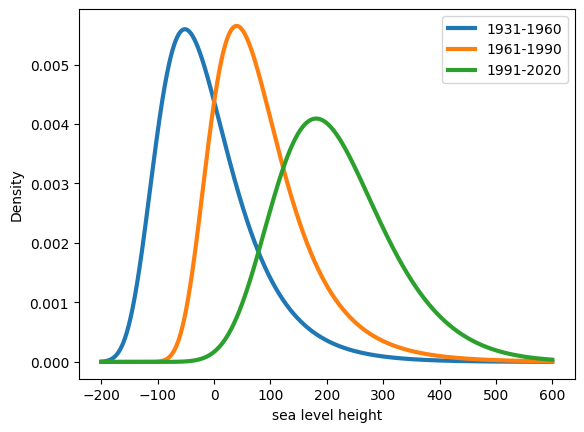

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(-200,600,1000)
ax.plot(x,gev.pdf(
    x, 
    -model_period1.shape.mean(), 
    loc=model_period1.loc.mean(), 
    scale=model_period1.scale.mean()
    ),
    c='C0',lw=3,label='1931-1960')
ax.plot(x,gev.pdf(
    x, 
    -model_period2.shape.mean(), 
    loc=model_period2.loc.mean(), 
    scale=model_period2.scale.mean()
    ),
    c='C1',lw=3,label='1961-1990')
ax.plot(x,gev.pdf(
    x, 
    -model_period3.shape.mean(), 
    loc=model_period3.loc.mean(), 
    scale=model_period3.scale.mean()
    ),
    c='C2',lw=3,label='1991-2020')
ax.legend()
ax.set_xlabel('sea level height')
ax.set_ylabel('Density')

Again we see a very clear shift towards higher values and a widening of the probability distribution. 
Finally we can have a look at the GEV parameters, how do they change. This will give a good sense of 
how we can incorporate non-stationarity in to our model in one of the next tutorials.

In [ ]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['1931-1960'] = [model_period1.loc.mean(), model_period1.scale.mean(), model_period1.shape.mean()]
parameters['1961-1990'] = [model_period2.loc.mean(), model_period2.scale.mean(), model_period2.shape.mean()]
parameters['1991-2020'] = [model_period3.loc.mean(), model_period3.scale.mean(), model_period3.shape.mean()]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

,Location,Scale,Shape
1931-1960,-49.9676,65.7964,0.0270
1961-1990,43.6208,65.2252,0.0560
1991-2020,172.2630,90.3313,-0.0946
